In [49]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data = pd.read_csv("..\employee_survey.csv")
# data3 = pd.get_dummies(data)

### Exploration

In [50]:
# Data Prep
data.head()

,EmpID,Gender,Age,MaritalStatus,JobLevel,Experience,Dept,EmpType,WLB,WorkEnv,...,SleepHours,CommuteMode,CommuteDistance,NumCompanies,TeamSize,NumReports,EduLevel,haveOT,TrainingHoursPerYear,JobSatisfaction
0,6,Male,32,Married,Mid,7,IT,Full-Time,1,1,...,7.6,Car,20,3,12,0,Bachelor,True,33.5,5
1,11,Female,34,Married,Mid,12,Finance,Full-Time,1,1,...,7.9,Car,15,4,11,0,Bachelor,False,36.0,5
2,33,Female,23,Single,Intern/Fresher,1,Marketing,Full-Time,2,4,...,6.5,Motorbike,17,0,30,0,Bachelor,True,10.5,5
3,20,Female,29,Married,Junior,6,IT,Contract,2,2,...,7.5,Public Transport,13,2,9,0,Bachelor,True,23.0,5
4,28,Other,23,Single,Junior,1,Sales,Part-Time,3,1,...,4.9,Car,20,0,7,0,Bachelor,False,20.5,5


In [51]:
cols = data.select_dtypes(include=['object', 'category']).columns
for col in cols:
    print(col)
    print(data[col].unique())

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 


Gender
['Male' 'Female' 'Other']
MaritalStatus
['Married' 'Single' 'Divorced' 'Widowed']
JobLevel
['Mid' 'Intern/Fresher' 'Junior' 'Senior' 'Lead']
Dept
['IT' 'Finance' 'Marketing' 'Sales' 'Operations' 'Customer Service'
 'Legal' 'HR']
EmpType
['Full-Time' 'Contract' 'Part-Time']
CommuteMode
['Car' 'Motorbike' 'Public Transport' 'Bike' 'Walk']
EduLevel
['Bachelor' 'High School' 'Master' 'PhD']


### Preprocess

In [112]:
# Nominal: Gender, Marital Status, Dept, EmpType, CommuteMode
# Ordinal: JobLevel, EduLevel
data2 = data.copy()
data2.drop(columns=['EmpID'], inplace=True)
le = LabelEncoder() 
ohe = OneHotEncoder()

# Ordinal
EduLevel_map = {'High School':1, 'Bachelor':2, 'Master':3, 'PhD':4}
JobLevel_map ={'Intern/Fresher':1, 'Junior':2, 'Mid':3, 'Senior':4, 'Lead':5}
data2['EduLevel'] = data2['EduLevel'].replace(EduLevel_map)
data2['JobLevel'] = data2['JobLevel'].replace(JobLevel_map)

# Nominal
Nominal = ['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode']
for feature in Nominal:
    data2 = encode_and_bind(data2, feature)

# Convert TrueFalse to int
data2['haveOT'] = data2['haveOT'].astype(int)

# Generate X and Y
X = data2.drop(columns=['JobSatisfaction'])
y = data2['JobSatisfaction']

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2)

# For classification
y_train1 = pd.get_dummies(y_train)
y_test1 = pd.get_dummies(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.toarray() if hasattr(X_train, "toarray") else X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray() if hasattr(X_test, "toarray") else X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# get a classification tensor
y_train_tensor1 = torch.tensor(y_train1.values, dtype=torch.float32).view(-1, 5)
y_test_tensor1 = torch.tensor(y_test1.values, dtype=torch.float32).view(-1, 5)

# print(X_train.shape)
# print(y_train.shape)
# print(y_train)
# print(y_train1)

### Model Design

In [ ]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(39, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

    
class NeuralNetworkClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(39, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 5)
        )
    def forward(self, x):
        return self.model(x)

### Training

In [115]:
batch_size = 64

# Create data loaders.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Make loaders for classification
train_dataset1 = TensorDataset(X_train_tensor, y_train_tensor1)
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size)

test_dataset1 = TensorDataset(X_test_tensor, y_test_tensor1)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 39])
Shape of y: torch.Size([64, 1]) torch.float32


#### Regression

In [105]:
# Code from Pytorch Quickstart 
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        loss = loss_fn(pred, y)
        # pred_rounded = np.clip(np.round(pred), 1, 5)
        # loss = loss_fn(pred_rounded, y).item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss/=len(dataloader)
    if verbose:
        print(f"Total Loss: {total_loss:>7f}")
    return total_loss

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_rounded = np.clip(np.round(pred), 1, 5)

            test_loss += loss_fn(pred_rounded, y).item()
            correct += (pred_rounded == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

Done!
Best Epoch: 482 Accuracy: 0.4644628099173554


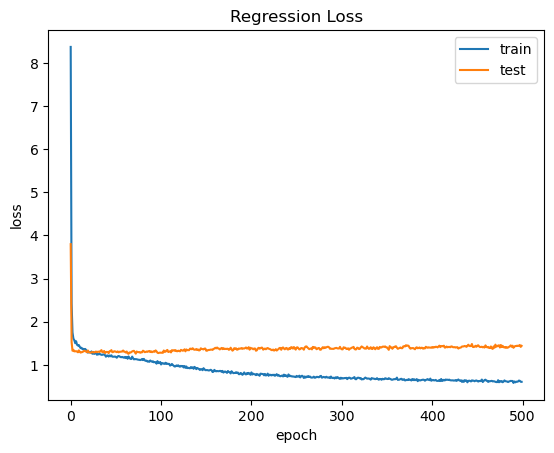

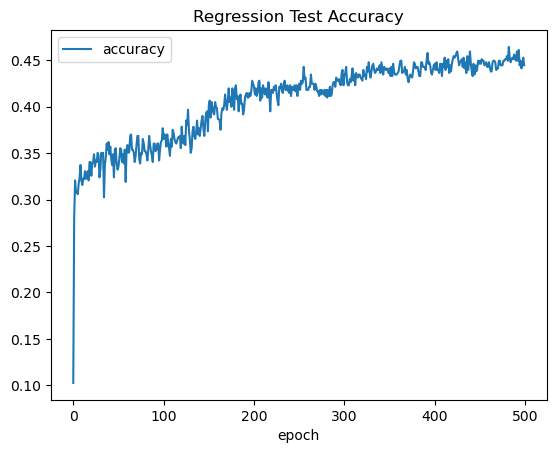

In [132]:
# Setting up problem
model = NeuralNetwork()
# print(model)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


trainLoss = []
testLoss = []
accuracy = []
# Training Loop
epochs = 500
verbose = False
for t in range(epochs):
    if verbose:
        print(f"Epoch {t+1}\n-------------------------------")
    trainingLost = train(train_loader, model, loss_fn, optimizer, verbose)
    # testingLoss, predictions, targets = test(test_loader, model, loss_fn)
    testingLoss, acc = test(test_loader, model, loss_fn, verbose)

    trainLoss.append(trainingLost)
    testLoss.append(testingLoss)
    accuracy.append(acc)

print("Done!")
print("Best Epoch: " + str(max(range(len(accuracy)), key=accuracy.__getitem__)) + " Accuracy: " + str(max(accuracy)))
plt.title("Regression Loss")
plt.plot(trainLoss, label="train")
plt.plot(testLoss, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(accuracy, label="accuracy")
plt.xlabel("epoch")
plt.title("Regression Test Accuracy")
plt.legend()
plt.show()


In [57]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#### Classification

In [124]:
# For classification
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train1(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        loss = loss_fn(pred, y)
        # pred_rounded = np.clip(np.round(pred), 1, 5)
        # loss = loss_fn(pred_rounded, y).item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss/=len(dataloader)
    if verbose:
        print(f"Total Loss: {total_loss:>7f}")
    return total_loss

def test1(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            # pred_rounded = np.clip(np.round(pred), 1, 5)

            test_loss += loss_fn(pred, y).item()

            finalClass = torch.argmax(pred, dim=1)
            # correct += (pred == y).type(torch.float).sum().item()
            # correct += (finalClass == y).type(torch.float).sum().item()
            correct += (finalClass == torch.argmax(y, dim=1)).float().sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

Done!
Best Epoch: 26 Accuracy: 0.5884297520661157


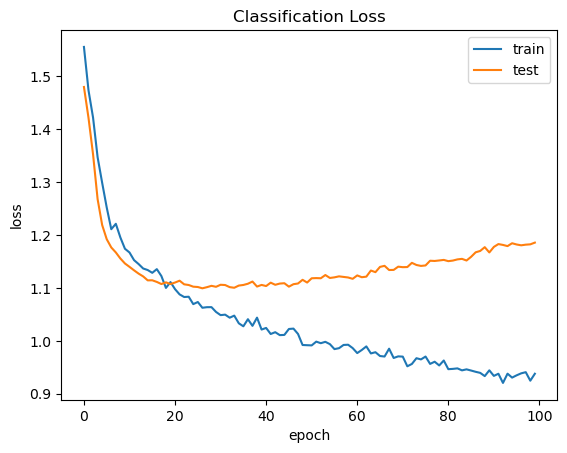

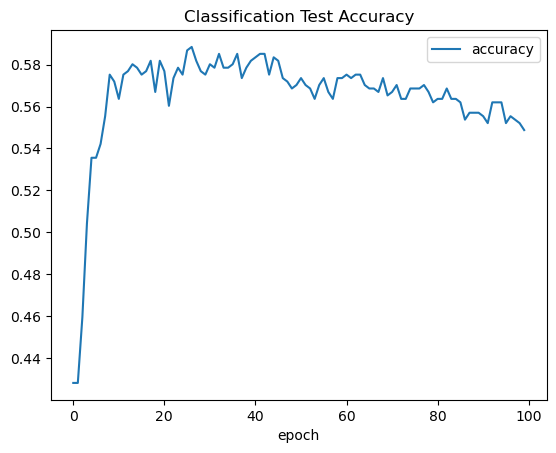

In [133]:
# Setting up problem
model1 = NeuralNetworkClassifier()
# print(model)
loss_fn1 = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)


trainLoss = []
testLoss = []
accuracy = []
# Training Loop
epochs = 100
verbose = False
for t in range(epochs):
    if verbose:
        print(f"Epoch {t+1}\n-------------------------------")
    trainingLost = train1(train_loader1, model1, loss_fn1, optimizer, verbose)
    # testingLoss, predictions, targets = test(test_loader, model, loss_fn)
    testingLoss, acc = test1(test_loader1, model1, loss_fn1, verbose)

    trainLoss.append(trainingLost)
    testLoss.append(testingLoss)
    accuracy.append(acc)

print("Done!")
# print(accuracy[-1])
print("Best Epoch: " + str(max(range(len(accuracy)), key=accuracy.__getitem__)) + " Accuracy: " + str(max(accuracy)))

plt.title("Classification Loss")
plt.plot(trainLoss, label="train")
plt.plot(testLoss, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(accuracy, label="accuracy")
plt.xlabel("epoch")
plt.title("Classification Test Accuracy")
plt.legend()
plt.show()

In [134]:
torch.save(model1.state_dict(), "model1.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Predict

In [ ]:
# model = NeuralNetwork()
# model.load_state_dict(torch.load("model.pth", weights_only=True))

# Not doing inference